In [11]:
import tensorflow as tf
from tensorflow.python.keras import models as m
from tensorflow.python.keras import layers as l

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.metrics import confusion_matrix, fbeta_score
from scikitplot.metrics import plot_roc, plot_confusion_matrix

import seaborn as sn
import pandas as pd

from ROOT import TFile, TTree, TChain
from ROOT import TH1F, TCanvas

import os
import sys
sys.path.insert(0, os.path.abspath('/home/arsahasransu/Documents/SoftDisplacedLeptons/Classifier/'))

print("All classes initialized successfully!!!")

All classes initialized successfully!!!


In [12]:
import plotBeautifier as pB

In [13]:
pB.trial_func("AR")

Trial works fine. Hello,AR


In [14]:
sigChan_BP_100_200 = TChain("varTree")
sigChan_BP_100_200.Add("signal_BP_100_200.root")
sigChan_BP_304_324 = TChain("varTree")
sigChan_BP_304_324.Add("signal.root")
bkgChan = TChain("varTree")
bkgChan.Add("background.root")
print("Data read from the trees. Printing out the contents.")

Data read from the trees. Printing out the contents.


In [15]:
sigChan_BP_100_200.Print()
sigChan_BP_304_324.Print()
bkgChan.Print()

******************************************************************************
*Chain   :varTree   : signal_BP_100_200.root                                 *
******************************************************************************
******************************************************************************
*Tree    :varTree   : Input Variables List for Algorithms                    *
*Entries :   228099 : Total =        16478088 bytes  File  Size =   14040221 *
*        :          : Tree compression factor =   1.17                       *
******************************************************************************
*Br    0 :HtJet     : HtJet/D                                                *
*Entries :   228099 : Total  Size=    1830615 bytes  File Size  =     116556 *
*Baskets :       58 : Basket Size=      32000 bytes  Compression=  15.69     *
*............................................................................*
*Br    1 :dRLL      : dRLL/D                        

In [16]:
# Read input data from root files
sigSampleSize_BP_100_200 = sigChan_BP_100_200.GetEntries()
sigSampleSize_BP_304_324 = sigChan_BP_304_324.GetEntries()
bkgSampleSize = bkgChan.GetEntries()

# Convert the input data to matrices
sigFull_BP_100_200 = sigChan_BP_100_200.AsMatrix()
sigFull_BP_304_324 = sigChan_BP_304_324.AsMatrix()
bkgFull = bkgChan.AsMatrix()

print(sigFull_BP_100_200.shape)
print(sigFull_BP_304_324.shape)
print(bkgFull.shape)

(228099, 9)
(44440, 9)
(4108, 9)


In [17]:
# Load the input data scaler
scaler = joblib.load("../scaler.save")

# Load the model
loaded_model = m.load_model("../simplePer.h5")
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                180       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 18)                342       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 38        
Total params: 560
Trainable params: 560
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Scalar transform the datasets
sig_BP_100_200_scaled = scaler.transform(sigFull_BP_100_200)
sig_BP_304_324_scaled = scaler.transform(sigFull_BP_304_324)
bkg_scaled = scaler.transform(bkgFull)

# Run the model on the input datasets to get the discriminator shape
sig_BP_100_200_predict = loaded_model.predict(sig_BP_100_200_scaled)
sig_BP_304_324_predict = loaded_model.predict(sig_BP_304_324_scaled)
bkg_predict = loaded_model.predict(bkg_scaled)

print(sig_BP_100_200_predict.shape)
print(sig_BP_304_324_predict.shape)
print(bkg_predict.shape)

(228099, 2)
(44440, 2)
(4108, 2)


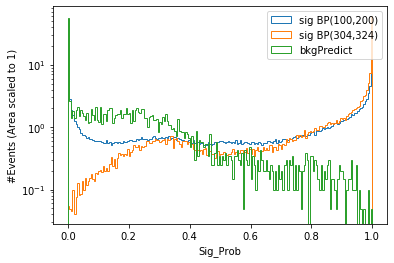

In [21]:
# Discriminator shape
plt.clf()
plt.yscale('log')
plt.hist(np.array(sig_BP_100_200_predict)[:,0], bins=200, range=(0,1), density=True, color=None, histtype='step', label='sig BP(100,200)')
plt.hist(np.array(sig_BP_304_324_predict)[:,0], bins=200, range=(0,1), density=True, color=None, histtype='step', label='sig BP(304,324)')
plt.hist(np.array(bkg_predict)[:,0], bins=200, range=(0,1), density=True, color=None, histtype='step', label='bkgPredict')
plt.xlabel("Sig_Prob")
plt.ylabel("#Events (Area scaled to 1)")
plt.legend()
plt.show()

In [10]:
# Discriminator Shape in ROOT plotting
c1 = TCanvas()
nBins = 20
sig_BP_100_200_histo = TH1F("","",nBins,0,1.01)
sig_BP_304_324_histo = TH1F("","",nBins,0,1.01)
bkg_histo = TH1F("","",nBins,0,1)
sig_BP_100_200_histo.FillN(sig_BP_100_200_predict.shape[0],
                           (sig_BP_100_200_predict[:,0]).astype(float),
                           np.ones(sig_BP_100_200_predict.shape[0]))
sig_BP_304_324_histo.FillN(sig_BP_304_324_predict.shape[0],
                           (sig_BP_304_324_predict[:,0]).astype(float),
                           np.ones(sig_BP_304_324_predict.shape[0]))
bkg_histo.FillN(bkg_predict.shape[0],
                (bkg_predict[:,0]).astype(float),
                np.ones(bkg_predict.shape[0]))

histList = [sig_BP_100_200_histo, sig_BP_304_324_histo, bkg_histo]
labelList = ['sig BP(100,200)', 'sig BP(304,324)', 'bkg']
xAxisTitle = "Sig_Prob"
yAxisTitle = "# Events (scaled to 1)"
outPlotName = "Discriminator_Beautified"
pB.plotBeautifier(histList, labelList, xAxisTitle, yAxisTitle, outPlotName)

Created a canvas
1
2
3


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: pdf file Discriminator_Beautified.pdf has been created


In [1]:
ctr=0
for layer in loaded_model.layers:
    nodes = layer.get_weights()
    for node in nodes[:-1]:
        for weight in node:
            print(len(weight))
    print(ctr,len(nodes))
    ctr = ctr+1
    
print(ctr)

NameError: name 'loaded_model' is not defined

In [26]:
a = np.array([[1,1,1,1,1,1,1,1,1],[0,0,0,0,0,0,0,0,0]])
print(a.shape)

(2, 9)


In [29]:
out = loaded_model.predict(a)
print(out)

[[0.78953654 0.21046348]
 [0.92062956 0.07937044]]
